In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from data.constants import ALL_LABELS_SORTED
import ast
from transformers import AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,EvalPrediction
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Preprocess input

In [3]:
# Path to csv files
WD = '../'
data_path = WD + 'data/'
save_path=WD +'data/milestone2'
train_df = pd.read_csv(data_path + 'train_data.csv')
valid_df = pd.read_csv(data_path + 'valid_data.csv')
test_df = pd.read_csv(data_path + 'test_data.csv')

In [4]:
def preprocess_labels(df: pd.DataFrame):
    labels =  df.iloc[:, [0, 2]].copy()
    labels.Labels = labels.Labels.apply(ast.literal_eval)
    mlb = MultiLabelBinarizer(classes=list(ALL_LABELS_SORTED.keys()))
    labels_transformed = mlb.fit_transform(labels['Labels'])
    labels[mlb.classes_] = labels_transformed
    return  labels


In [5]:
train_labels=preprocess_labels(train_df)
valid_labels=preprocess_labels(valid_df)
test_labels=preprocess_labels(test_df)

train_sent=train_df['Text'].tolist()
valid_sent=valid_df["Text"].tolist()
test_sent=test_df["Text"].tolist()

model_ckpt = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt,problem_type="multi_label_classification")

train_encodings = tokenizer(train_sent,truncation=True,padding=True,return_tensors='pt')
valid_encodings = tokenizer(valid_sent, truncation=True, padding=True, return_tensors='pt')
test_encodings=tokenizer(test_sent, truncation=True, padding=True, return_tensors='pt')

In [6]:
class BRISEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        #item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.FloatTensor(self.labels.iloc[idx,2:])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
train_dataset = BRISEDataset(train_encodings, train_labels)
valid_dataset=BRISEDataset(valid_encodings,valid_labels)
test_dataset=BRISEDataset(test_encodings,test_labels)

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=len(ALL_LABELS_SORTED),problem_type="multi_label_classification").to("cuda")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [9]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [10]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

In [11]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [12]:
batch_size=8
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
                                  num_train_epochs=6,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  optim="adamw_torch",
                                  metric_for_best_model = "f1",
                                  save_strategy = "epoch")

In [13]:
from transformers import  Trainer,ProgressCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[ProgressCallback]
)


In [14]:
trainer.train()

***** Running training *****
  Num examples = 5368
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4026
  Number of trainable parameters = 278115165


  0%|          | 0/4026 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.102000,0.060489,0.000000,0.500000,0.357054
2,0.063300,0.048369,0.360429,0.610398,0.419476
3,0.044800,0.040283,0.577613,0.718869,0.474407
4,0.036900,0.031047,0.635526,0.742638,0.515605
5,0.031800,0.026937,0.717654,0.792886,0.549313
6,0.025900,0.025457,0.740193,0.805621,0.578027


{'loss': 0.102, 'learning_rate': 4.379036264282166e-05, 'epoch': 0.75}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.06048929691314697, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.3570536828963795, 'eval_runtime': 12.7201, 'eval_samples_per_second': 62.971, 'eval_steps_per_second': 7.94, 'epoch': 1.0}


Saving model checkpoint to test_trainer/checkpoint-671
Configuration saved in test_trainer/checkpoint-671/config.json
Model weights saved in test_trainer/checkpoint-671/pytorch_model.bin


{'loss': 0.0633, 'learning_rate': 3.758072528564332e-05, 'epoch': 1.49}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.0483686625957489, 'eval_f1': 0.36042944785276076, 'eval_roc_auc': 0.6103982843331757, 'eval_accuracy': 0.41947565543071164, 'eval_runtime': 12.7097, 'eval_samples_per_second': 63.022, 'eval_steps_per_second': 7.947, 'epoch': 2.0}


Saving model checkpoint to test_trainer/checkpoint-1342
Configuration saved in test_trainer/checkpoint-1342/config.json
Model weights saved in test_trainer/checkpoint-1342/pytorch_model.bin


{'loss': 0.0538, 'learning_rate': 3.137108792846498e-05, 'epoch': 2.24}
{'loss': 0.0448, 'learning_rate': 2.516145057128664e-05, 'epoch': 2.98}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.04028306156396866, 'eval_f1': 0.5776128633271491, 'eval_roc_auc': 0.7188692875231016, 'eval_accuracy': 0.47440699126092384, 'eval_runtime': 12.8038, 'eval_samples_per_second': 62.559, 'eval_steps_per_second': 7.888, 'epoch': 3.0}


Saving model checkpoint to test_trainer/checkpoint-2013
Configuration saved in test_trainer/checkpoint-2013/config.json
Model weights saved in test_trainer/checkpoint-2013/pytorch_model.bin


{'loss': 0.0369, 'learning_rate': 1.8951813214108295e-05, 'epoch': 3.73}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.031046845018863678, 'eval_f1': 0.6355255070682237, 'eval_roc_auc': 0.7426379000757419, 'eval_accuracy': 0.5156054931335831, 'eval_runtime': 12.1687, 'eval_samples_per_second': 65.824, 'eval_steps_per_second': 8.3, 'epoch': 4.0}


Saving model checkpoint to test_trainer/checkpoint-2684
Configuration saved in test_trainer/checkpoint-2684/config.json
Model weights saved in test_trainer/checkpoint-2684/pytorch_model.bin


{'loss': 0.0318, 'learning_rate': 1.2742175856929956e-05, 'epoch': 4.47}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.026936819776892662, 'eval_f1': 0.7176538240368026, 'eval_roc_auc': 0.7928858084690679, 'eval_accuracy': 0.5493133583021224, 'eval_runtime': 12.1165, 'eval_samples_per_second': 66.108, 'eval_steps_per_second': 8.336, 'epoch': 5.0}


Saving model checkpoint to test_trainer/checkpoint-3355
Configuration saved in test_trainer/checkpoint-3355/config.json
Model weights saved in test_trainer/checkpoint-3355/pytorch_model.bin


{'loss': 0.0276, 'learning_rate': 6.532538499751614e-06, 'epoch': 5.22}
{'loss': 0.0259, 'learning_rate': 3.229011425732737e-07, 'epoch': 5.96}


***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.02545725181698799, 'eval_f1': 0.7401932916429789, 'eval_roc_auc': 0.8056214434853289, 'eval_accuracy': 0.5780274656679151, 'eval_runtime': 12.758, 'eval_samples_per_second': 62.784, 'eval_steps_per_second': 7.917, 'epoch': 6.0}


Saving model checkpoint to test_trainer/checkpoint-4026
Configuration saved in test_trainer/checkpoint-4026/config.json
Model weights saved in test_trainer/checkpoint-4026/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 2107.9529, 'train_samples_per_second': 15.279, 'train_steps_per_second': 1.91, 'train_loss': 0.04807510363540422, 'epoch': 6.0}


TrainOutput(global_step=4026, training_loss=0.04807510363540422, metrics={'train_runtime': 2107.9529, 'train_samples_per_second': 15.279, 'train_steps_per_second': 1.91, 'train_loss': 0.04807510363540422, 'epoch': 6.0})

In [15]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 801
  Batch size = 8


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.02545725181698799,
 'eval_f1': 0.7401932916429789,
 'eval_roc_auc': 0.8056214434853289,
 'eval_accuracy': 0.5780274656679151,
 'eval_runtime': 12.8096,
 'eval_samples_per_second': 62.531,
 'eval_steps_per_second': 7.885,
 'epoch': 6.0}

In [16]:
## tof flush cuda memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
prediction = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 665
  Batch size = 8


  0%|          | 0/84 [00:00<?, ?it/s]

In [66]:
prediction

PredictionOutput(predictions=array([[ -4.268567  ,  -5.390313  ,  -4.998816  , ..., -10.685153  ,
        -10.232236  , -10.881948  ],
       [ -4.288045  ,  -5.233083  ,  -0.88267624, ...,  -9.230505  ,
         -8.670232  ,  -9.316888  ],
       [ -3.7342815 ,  -4.9864893 ,   0.38795215, ...,  -8.541333  ,
         -7.8916326 ,  -8.344463  ],
       ...,
       [  3.873316  ,  -2.418399  ,  -4.015788  , ...,  -7.1492066 ,
         -7.062077  ,  -7.7242618 ],
       [  2.7632945 ,  -3.613787  ,  -4.2997518 , ...,  -6.5792985 ,
         -6.335207  ,  -6.7535152 ],
       [ -4.2729087 ,  -5.41334   ,  -4.9651937 , ..., -10.669596  ,
        -10.225849  , -10.870003  ]], dtype=float32), label_ids=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), metrics={'test_loss': 0.024115478619933

In [87]:
predictions = (np.sign(prediction.predictions)+1)/2
true_labels = test_dataset.labels.iloc[:,2:]

# Confusion Matrices

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

In [69]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

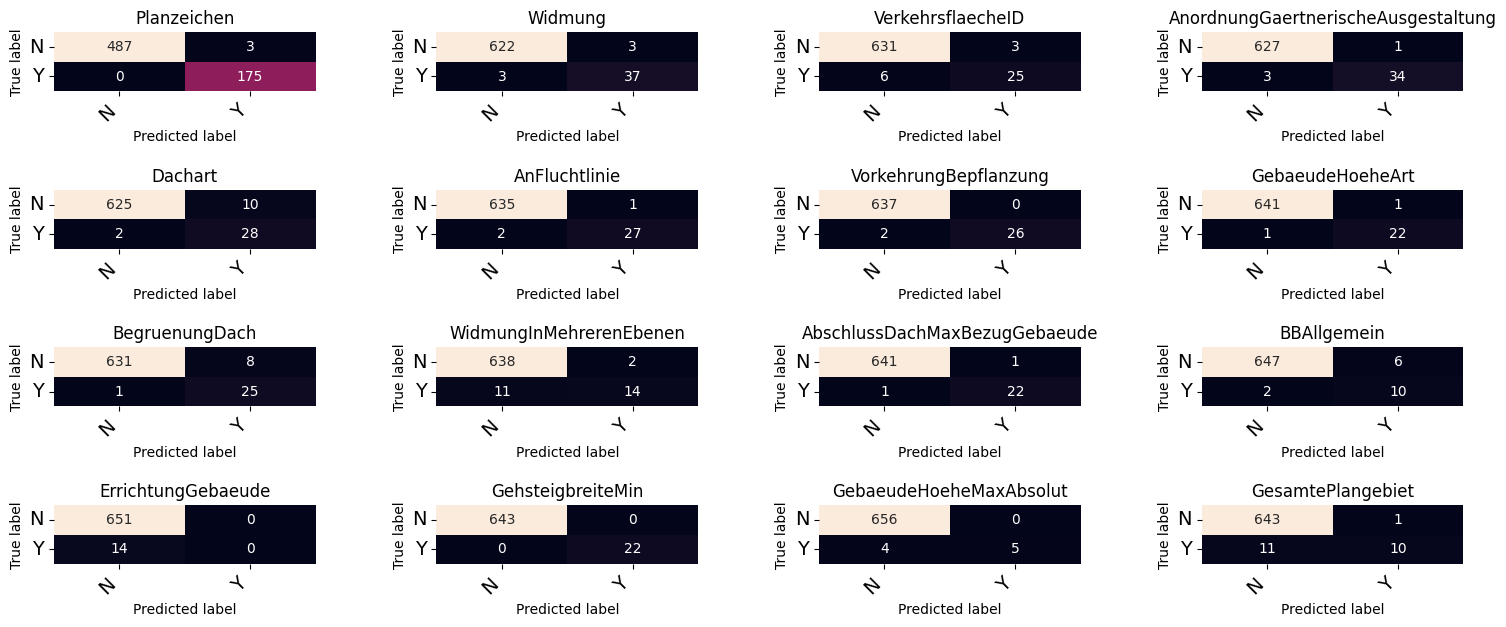

In [88]:
vis_arr = multilabel_confusion_matrix(true_labels, predictions)
labels =  true_labels.columns
fig, ax = plt.subplots(4, 4, figsize=(16, 7))
fig.tight_layout(pad=5.0)

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

plt.show()